In [1]:
import sys

DATA_PATH = '../../IFT6758_Data/'
PROJECT_PATH = '../../Milestone2/'


sys.path.append(PROJECT_PATH)

In [2]:
from comet_ml import Experiment
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
import shap
import pickle
import matplotlib.pyplot as plt
import sklearn
import imblearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectFromModel
import os
import xgboost as xgb

from visualizations.simple_visualization import *
from models.generate_plots import *
from features.feature_eng1 import *

In [3]:
X = pd.read_csv(DATA_PATH + '/clean_train_data.csv', index_col=0)

In [4]:
has_nan = X.isna().any().any()
# print(X[X.isna().any(axis=1)].index)
# data.iloc[X[X.isna().any(axis=1)].index]

if has_nan:
    print("There are NaN values in the DataFrame 'X'.")
    # Dropping NaNs since these events do not have x and y coordinates
    X.dropna(inplace=True)
    X = X.reset_index(drop=True)
else:
    print("There are no NaN values in the DataFrame 'X'.")
X.shape
X.dtypes
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X.reset_index(drop=True)

There are NaN values in the DataFrame 'X'.


In [5]:
X, y = X.iloc[:, :-1], X.iloc[:, -1]
y.value_counts(normalize=True).round(2)*100

0    91.0
1     9.0
Name: is_goal, dtype: float64

In [6]:
num_cols = X.select_dtypes([np.number]).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

categorical_cols = X.select_dtypes(exclude=["number", "bool_"]).columns
X = pd.get_dummies(data=X, columns=categorical_cols)

boolean_cols = X.select_dtypes([bool]).columns
X[boolean_cols] = X[boolean_cols].astype(int)
X = X.reset_index(drop=True)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [9]:
# Reference: https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688

sm = imblearn.over_sampling.SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [11]:
params = {'objective':'binary:logistic',
 'booster': 'gbtree',
 'lambda': 0.04546869697224418,
 'alpha': 0.21038300757945416,
 'max_depth': 6,
 'eta': 0.28859193916460457,
 'gamma': 8.4213865886515e-05,
 'grow_policy': 'depthwise'}

model = xgb.XGBClassifier(**params)

model.fit(X_res, y_res)

XGBClassifier(alpha=0.21038300757945416, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.28859193916460457,
              eval_metric=None, gamma=8.4213865886515e-05, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.04546869697224418,
              learning_rate=0.288591951, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [12]:
y_pred = model.predict(X_val)
accuracy = metrics.accuracy_score(y_val, y_pred)
print(f'Accuracy score is {accuracy}')

Accuracy score is 0.9051938811810744


In [13]:
sm_f1 = metrics.f1_score(y_val, y_pred)
sm_accuracy = metrics.accuracy_score(y_val, y_pred)
sm_precision = metrics.precision_score(y_val, y_pred)
sm_recall = metrics.recall_score(y_val, y_pred)

In [14]:
pickle.dump(model, open("smote_xgb_model.pkl", "wb"))

In [15]:
experiment = Experiment(
  api_key='lqXuPyhuPClaazZKtvHZe5jFS',
  project_name="nhl-project-b10",
  workspace="ift6758b-project-b10"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758b-project-b10/nhl-project-b10/49b3fa645cce4495ab81956603b4d80c



In [16]:
evaluation = {"accuracy": sm_accuracy, "f1": sm_f1, "recall": sm_recall, "precision": sm_precision}
params = {
    "model": 'XGBoost with Tomek Links',
    "description": 'XGBoost Classifier with Tomek Links',
    **model.get_params()
}

In [17]:
experiment.set_name('XGBoost with SMOTE Oversampling')
experiment.log_parameters(params)
experiment.log_metrics(evaluation)

experiment.log_model('6-3 XGBoost Classifier with SMOTE Oversampling', 'smote_xgb_model.pkl')

{'web': 'https://www.comet.com/api/asset/download?assetId=14b69431a6a44d40acda3b31c8147e2b&experimentKey=49b3fa645cce4495ab81956603b4d80c',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=14b69431a6a44d40acda3b31c8147e2b&experimentKey=49b3fa645cce4495ab81956603b4d80c',
 'assetId': '14b69431a6a44d40acda3b31c8147e2b'}

In [18]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758b-project-b10/nhl-project-b10/49b3fa645cce4495ab81956603b4d80c
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9051938811810744
COMET INFO:     f1        : 0.0499108734402852
COMET INFO:     precision : 0.3090909090909091
COMET INFO:     recall    : 0.027147256758298162
COMET INFO:   Others:
COMET INFO:     Name : XGBoost with SMOTE Oversampling
COMET INFO:   Parameters:
COMET INFO:     alpha                   : 0.21038300757945416
COMET INFO:     base_score              : 0.5
COMET INFO:     booster                 : gbtree
COMET INFO:     callbacks               : None
COMET INFO:     colsample_bylevel       : 1
CO

In [19]:
y_pred_prob = model.predict_proba(X_val)[:, 1]
df_percentile =  calc_percentile(y_pred_prob, y_val)

goal_rate_df = goal_rate(df_percentile)

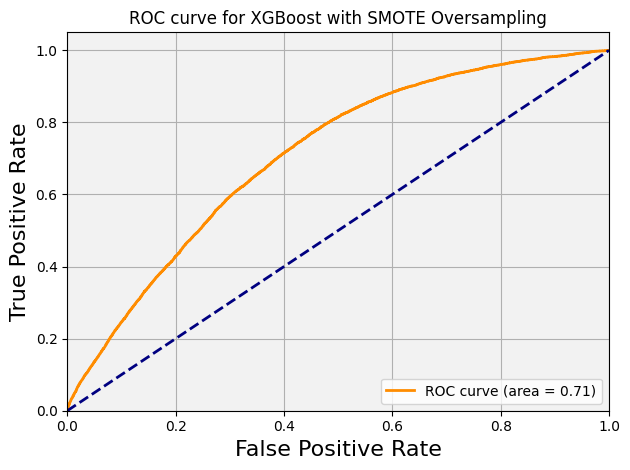

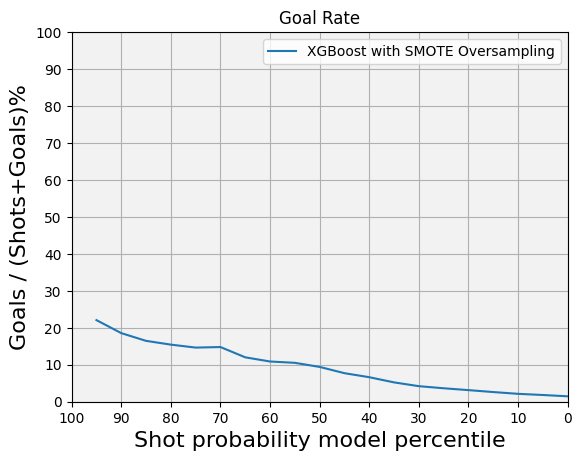

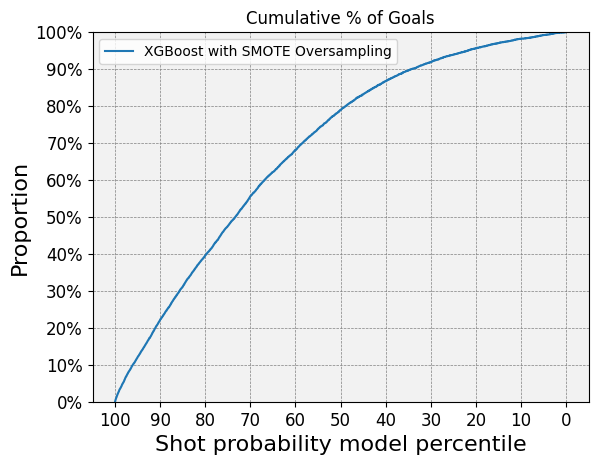

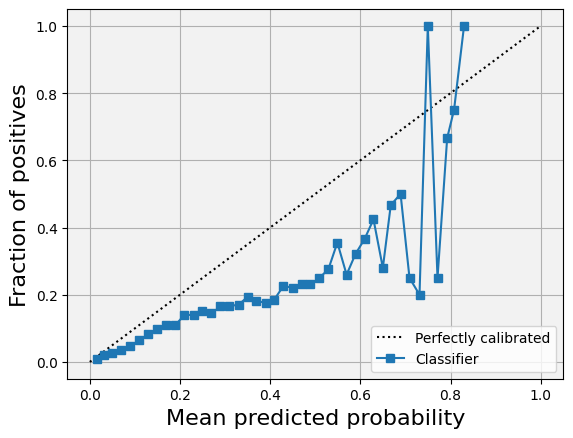

In [20]:
plot_ROC(y_val, y_pred_prob, 'ROC curve for XGBoost with SMOTE Oversampling', '6-3a ROC Curve')
plot_goal_rates(goal_rate_df, 'XGBoost with SMOTE Oversampling', '6-3b Goal Rate')
plot_cumulative_goal_rates(df_percentile, 'XGBoost with SMOTE Oversampling', '6-3c Cumulative Goal Percentage')
plot_calibration_curve_prediction(y_val, y_pred_prob, '6-3d Calibration Plot')